# Thermodynamics

The thermodynamic modules interfaces with pycalphad to perform important calculations for the KWN model. They are split into two classes to handle binary and multicomponent systems.

Setting up a Thermodynamics object requires the database, the elements involved (where first element will be the reference element) and the phases involved (where the first phase will be the matrix phase). For systems where the parent and precipitate phases are handled by an order/disorder model (ex. $\gamma$ and $\gamma$' in nickel-based alloys), the matrix phase is assumed to be the disordered part of the model.

For multicomponent systems, any compositions that is used as a parameter or as a return value will be in the same order of solutes that was used when creating the Thermodynamics object. In the example below, all compositions will be in the order [xCr, xAl]. If the solutes were ordered as ['Ni', 'Al', 'Cr'] in the constructor, then all compositions will be in the order [xAl, xCr].

In [1]:
from kawin.thermo import BinaryThermodynamics, MulticomponentThermodynamics

binaryTherm = BinaryThermodynamics('AlScZr.tdb', ['AL', 'ZR'], ['FCC_A1', 'AL3ZR'])
multiTherm = MulticomponentThermodynamics('NiCrAl.tdb', ['NI', 'CR', 'AL'], ['FCC_A1', 'FCC_L12'])

## Hyperparameters

### Sampling density

When calculating equilibrium, pycalphad samples the free energy surfaces of each phase to find a suitable starting point for the free energy minimization procedure. The sampling density (defined as the number of samples to create per degree of freedom in the free energy model) can influence the accuracy of the equilibrium results and the computation time. A low sampling density may lead to inaccurate results while a high sampling density may result in slow calculations. By default, the Thermodynamics object sets the sampling density to 500.

There is a second sampling density parameter that is used when calculating the driving force using the sampling method. By default, it is set to 2000. This sampling density is set to be higher than for the sampling density used for solving equilibrium because the samples themselves are used in the driving force calculations.

In [2]:
#Change sampling density
multiTherm.setEQSamplingDensity(500)

#Change driving force sampling density
multiTherm.setDFSamplingDensity(2000)

### Moblity correction factors

For mobility terms, a correction factor can be applied to each element. This may be useful in parameter assessment, sensitivity analysis or in cases where the mobility will be known to be higher (e.g. higher vacancy concentrations from a solutionizing/quenching treatment).

In [3]:
#Change mobility factor for Cr
multiTherm.setMobilityCorrection('Cr', 1)

#Change mobility factor for all components
multiTherm.setMobilityCorrection('all', 1)

### Starting conditions for Binary Systems

For BinaryThermodynamics, the interfacial composition is independent of the composition of the system and is calculated by solving equilibrium at several compositions until a 2-phase region is found. By default, it samples the composition in intervals of 0.1. The starting compositions can be manually set to always be inside the 2-phase region to improve computation time.

In [4]:
#Change starting conditions for BinaryThermodynamics

#Compositions between 0 and 0.5 at intervals of 0.015
binaryTherm.setGuessComposition((0, 0.5, 0.015))

#Single composition at 0.24
binaryTherm.setGuessComposition(0.24)

## Driving Force Calculations

### Nucleation

Nucleation of a precipitate results in a reduction in Gibbs free energy that scales with the precipitate volume and an increase in the free energy that scales with the surface, creating a barrier for nucleation.

$$\Delta G = -\frac{4}{3}\pi R^3 \Delta G_{vol} + 4\pi R^2 \gamma$$

The height of this barrier, $\Delta G^{*}$, can be used to find the nucleation rate.

$$J_N = N_0 Z \beta exp\left(-\frac{\Delta G^{*}}{k_B T}\right) exp\left(-\frac{\tau}{t}\right)$$

The driving force is defined as the maximum difference in Gibbs free energy between the chemical potential hyperplane computed for the matrix ($\alpha$) and precipitate ($\beta$) phase separately. This can also be defined as the difference in the Gibbs free energy when the chemical potential hyperplanes of each phase are parallel. The chemical potential of the $\alpha$ is computed at the matrix composition while the chemical potential of the $\beta$ phase is computed at the composition which maximizes the driving force (Rheingans and Mittemeijer, 2015).

$$\Delta G_m = \sum{x_A^\beta \, \mu_A^\alpha (\boldsymbol{x}^\alpha) - x_A^\beta \, \mu_A^\beta (\boldsymbol{x}^\beta)} = \left(\frac{2 \gamma}{R^*} + \Delta G_{el}\right) V_m^\beta$$

Four different methods are available for driving force calculations: tangent, approximate, sampling and curvature.

### Tangent method

Rather than calculating equilibrium of the precipitate phase to have a parallel chemical potential hyperplane, the tangent method solves for the energy offset that puts the precipitate phase on the chemical potential hyperplane of the matrix phase. This is the default method when the Thermodynamics object is created.

### Approximate method

The approximate method assumes that the composition of a newly nucleated precipitate is near the equilibrium composition. 

$$ \Delta G_M = \sum_{A}{x_{eq}^\beta \, \mu_A^\alpha \left(\boldsymbol{x^\alpha}\right) - x_{eq}^\beta \, \mu_A^\beta \left(\boldsymbol{x_{eq}^\beta}\right)} $$

### Sampling method

The sampling method approximates calculating the driving force by the parallel tangent method. Rather than finding the composition of the precipitate phase that gives the same chemical potential as for the parent phase, the maximum difference between Gibbs free energy of the precipitate phase and the chemical potential hyperplane of the parent phase is found. This is the only method of the three that can calculate negative driving forces and is used by the other two methods if the precipitate phase is unstable.
$$ \Delta G_M = argmax \left(\sum_{A}{x_A^\beta \, \mu_A^\alpha \left(\boldsymbol{x^\alpha}\right)} - G_M^\beta \left(\boldsymbol{x^\beta}\right) \right) $$

### Curvature method

The curvature method determines the local curvature of the free energy surface of the parent phase at the given composition and calculates driving force based off the equilibrium composition of the parent and precipitate phase. This is only valid for small supersaturations and non-dilute systems and thus, is not recommended.
$$ \Delta G_M = \boldsymbol{\left(x^\alpha - x_{eq}^\alpha\right)} \boldsymbol{\nabla^2} G_M^\alpha \boldsymbol{\left(x_{eq}^\beta - x_{eq}^\alpha\right)} $$

### Binary System

For a binary system, the driving force method is defined as:

$ \Delta G_M, x^\beta = BinaryThermodynamics.getDrivingForce(x, T, returnComp) $

The example below compares the three methods on the Al-Zr system. The approximate and sampling method gives the same values for the driving force. This is due to the $Al_3Zr$ having zero degrees of freedom for the composition, so the calculation of the driving force ends up being the same. The curvature method is only accurate near the equilibrium composition (where the driving force is 0), but at higher concentrations, it greatly over predicts the driving force. This is due to the high curvature at low concentrations.

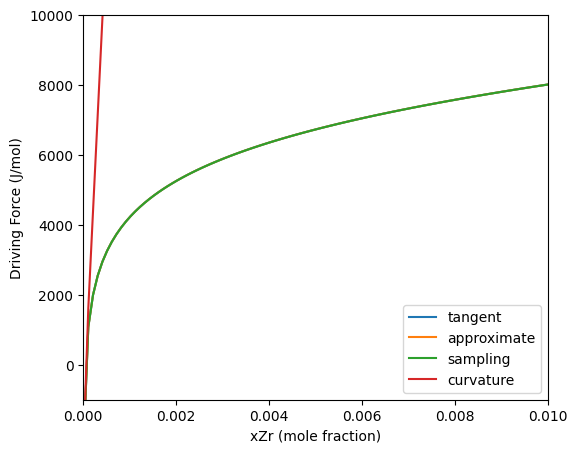

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#Plot comparison of driving force methods for Al-Zr system

#Driving force methods
DGmethods = ['tangent', 'approximate', 'sampling', 'curvature']

x = np.linspace(1e-5, 1e-2, 100)

fig1 = plt.figure(1, figsize=(6, 5))
ax1 = fig1.add_subplot(111)

for m in DGmethods:
    #Clear cache before using a different method
    binaryTherm.clearCache()
    binaryTherm.setDrivingForceMethod(m)

    #Calculate driving force (x and T must be same shape)
    dg, _ = binaryTherm.getDrivingForce(x, np.ones(100) * 673.15)
    ax1.plot(x, dg, label=m)

ax1.set_xlim([0, 0.01])
ax1.set_ylim([-1000, 10000])
ax1.set_xlabel('xZr (mole fraction)')
ax1.set_ylabel('Driving Force (J/mol)')
ax1.legend(DGmethods)

### Multicomponent systems

For multicomponent systems, the driving force method is defined as:

$ \Delta G_M, \boldsymbol{x^\beta} = MulticomponentThermodynamics.getDrivingForce(\boldsymbol{x}, T, returnComp) $

This is similar to the method for binary systems except that the composition must be an array of the solute components. Below is an example of the different driving force methods in the Ni-Cr-Al system. Because the equilibrium composition is non-dilute, the curvature method gives similar values to the other two methods. Once the driving force becomes negative (no driving force for nucleation), the three methods converge since the sampling method is used if the precipitate is unstable.

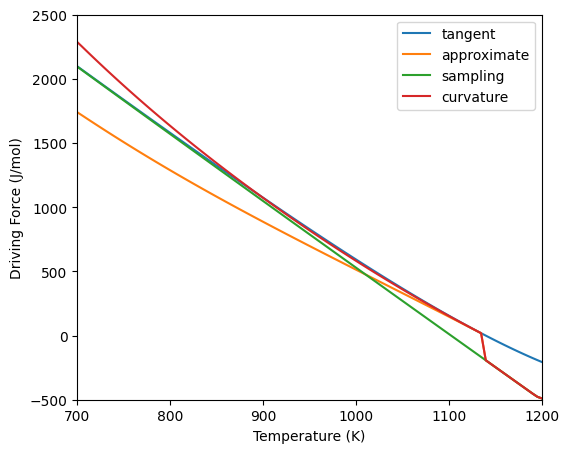

In [6]:
#Driving force for NiCrAl system

#Create points to calculate driving force at
# x and T must be same length
comps = np.array([[0.08, 0.1] for i in range(100)])
T = np.linspace(700, 1200, 100)

fig2 = plt.figure(2, figsize=(6, 5))
ax2 = fig2.add_subplot(111)

for m in DGmethods:
    #Clear cache before switching method
    multiTherm.clearCache()
    multiTherm.setDrivingForceMethod(m)

    #Calculate driving force
    dg, xP = multiTherm.getDrivingForce(comps, T)
    ax2.plot(T, dg, label=m)

ax2.set_xlim([700, 1200])
ax2.set_ylim([-500, 2500])
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Driving Force (J/mol)')
ax2.legend(DGmethods)

## Interfacial Composition and Precipitate Growth Rates

### Binary Systems

Assuming diffusion controlled growth, the growth rate of a spherical preciptiate in a binary system can be written as:

$$ \frac{dR}{dt} = \frac{D}{R} \frac{x - x_R^\alpha}{x_R^\beta - x_R^\alpha} $$

Where $x_R^\alpha$ and $x_R^\beta$ is the interfacial composition of the matrix and precipitate phase respectively. For binary systems, the interfacial composition is independent of the composition of the system. This becomes useful in the KWN model as these values can be calculated beforehand and used for determining the growth rate, rather than calculating them at every iteration.

Determining the interfacial composition requires solving for equilibrium while accounting for the Gibbs-Thompson effect (proportional to 1/r). Elastic energy can also be accounted for.

$$\mu_i^\alpha (\boldsymbol{x_R^\alpha}) = \mu_i^\beta (\boldsymbol{x_R^\beta}) + \left(\frac{2 \gamma}{R} + \Delta G_{el}\right) V_m^\beta$$

For a binary system, the interfacial composition can be calculated from the curvature of the Gibbs free energy surfaces similar to the curvature method for calculating driving force:
$$ \left(\frac{2 \gamma}{R} + \Delta G_{el}\right) V_m^\beta = \boldsymbol{\left(x^\alpha - x_{eq}^\alpha\right)} \boldsymbol{\nabla^2} G_M^\alpha \boldsymbol{\left(x_{eq}^\beta - x_{eq}^\alpha\right)} $$

For composition of the precipitate:
$$ \boldsymbol{\nabla^2} G_M^\beta \boldsymbol{\left(x^\beta - x_{eq}^\beta\right)} = \boldsymbol{\nabla^2} G_M^\alpha \boldsymbol{\left(x^\alpha - x_{eq}^\alpha\right)} $$

As with the curvature method for calculating driving force, the curvature method for calculating interfacial composition is only valid for small supersaturations and non-dilute systems. Additionally, while these two equations can be generalized to multicomponent systems, they are generally indeterminate and the interfacial compositions in multicomponent systems cannot be determined by the free energy curvature alone.

The interfacial composition method for binary systems is defined as:

$ x^\alpha, x^\beta = BinaryThermodynamics.getInterfacialComposition(T, G_{TH}) $

Where $G_{TH}$ is the free energy contribution from the Gibbs-Thomson effect. The example below compares the two methods for calculating the interfacial composition in the matrix phase. If $G_{TH}$ is too large such that the precipitate phase becomes unstable, then the function will return -1 for both the matrix and precipitate compostion.

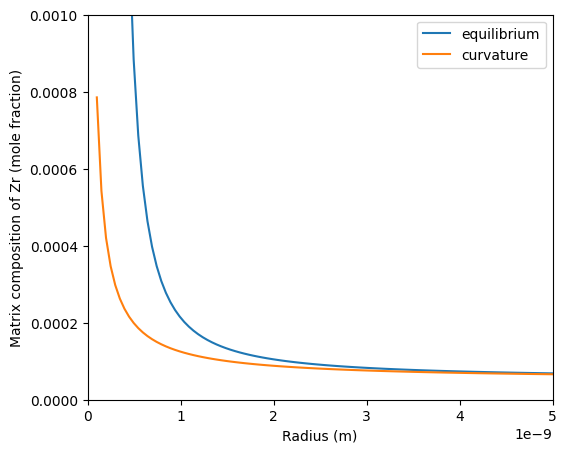

In [7]:
#Interfacial composition for Al-Zr system

#Different methods for calculating interfacial composition
ICmethods = ['equilibrium', 'curvature']

#Get Gibbs-Thomson contribution from radius
gamma = 0.1 #Interfacial energy between FCC-Al and Al3Zr
Vm = 1e-5   #Molar volume
R = np.linspace(1e-10, 5e-9, 100)   #Radius
G = 2 * gamma * Vm / R              #Contribution from Gibbs-Thomson effect

fig3 = plt.figure(3, figsize=(6, 5))
ax3 = fig3.add_subplot(111)

for m in ICmethods:
    binaryTherm.clearCache()
    binaryTherm.setInterfacialMethod(m)

    #Calculate interfacial composition
    xM, xP = binaryTherm.getInterfacialComposition(673.15, G)
    ax3.plot(R[xM != -1], xM[xM != -1], label=m)

ax3.set_xlim([0, 5e-9])
ax3.set_ylim([0, 0.001])
ax3.set_xlabel('Radius (m)')
ax3.set_ylabel('Matrix composition of Zr (mole fraction)')
ax3.legend(ICmethods)

## Multicomponent Systems

The governing equations for solving multicomponent precipitate is the same as for binary precipitation. However, calculating interfacial composition through solving for equilibrium requires the solution to the following equations for each component.

$$\frac{dR}{dt} = \sum_{j}{\frac{D_{ij}}{R} \frac{x_i - x_{R,i}^{\alpha}}{x_{R,j}^{\beta} - x_{R,j}^{\alpha}}}$$

$$\mu_i^\alpha (\boldsymbol{x_R^\alpha}) = \mu_i^\beta (\boldsymbol{x_R^\beta}) + \left(\frac{2 \gamma}{R} + \Delta G_{el}\right) V_m^\beta$$

This gives 2N-1 equations to solve, which can be time consuming and, in worst cases, a solution may not be found. At small saturations, the growth rate can be determined through local expansion of the chemical potential at equilibrium (Philippe and Voorhees, 2013). The growth rate (assuming $\Delta G_{el} = 0$ for simplicity) then becomes:

$$\frac{dR}{dt}=\frac{1}{R (\boldsymbol{\Delta \overline{x}})^T M^{-1} \boldsymbol{\Delta \overline{x}}}\left(\Delta G_m - \frac{2 \gamma V_m^\beta}{R}\right)$$


$$\boldsymbol{\Delta \overline{x} = x_{\infty}^{\beta} - x_{\infty}^{\alpha}}$$

Where $\boldsymbol{x_{\infty}^{\alpha}}$ and $\boldsymbol{x_{\infty}^{\beta}}$ are the equilibrium compositions of $\alpha$ and $\beta$ on a planar interface and $M^{-1} = \boldsymbol{\nabla^2} G^{\alpha} * D^{-1}$, where $\boldsymbol{\nabla^2} G^{\alpha}$ is the curvature of the free energy surface of phase $\alpha$ and $D^{-1}$ is the inverse of the interdiffusivity matrix.

Interfacial compositions can be determined by the following equations, which are needed for solving mass balance.

$$\boldsymbol{x^{\alpha}} = \boldsymbol{x} - \frac{D^{-1} \boldsymbol{\Delta \overline{x}}}{(\boldsymbol{\Delta \overline{x}})^T M^{-1} \boldsymbol{\Delta \overline{x}}} \left(\Delta G_m - \frac{2 \gamma V_m^\beta}{R}\right)$$


$$\boldsymbol{x^\beta} = \boldsymbol{x_{\infty}^{\beta}} + \left(\boldsymbol{\nabla^2} G^\beta \right)^{-1} \boldsymbol{\nabla^2} G^{\alpha}\left(\boldsymbol{x-x_{\infty}^{\alpha}}\right)$$

The growth rate and interfacial composition method for multicomponent systems is defined as:

$ \frac{dR}{dt}, \boldsymbol{x^\alpha}, \boldsymbol{x^\beta}, \boldsymbol{x_{\infty}^{\alpha}}, \boldsymbol{x_{\infty}^{\beta}} = MulticomponentThermodynamics.getGrowthAndInterfacialComposition(\boldsymbol{x}, T, \Delta G_M, R, G_{TH}) $

Where $\Delta G_M$ is the driving force at composition $\boldsymbol{x}$ and temperature $T$, $R$ is the precipitate radius and $G_{TH}$ is the free energy contribution from the Gibbs-Thomson effect corresponding to $R$.

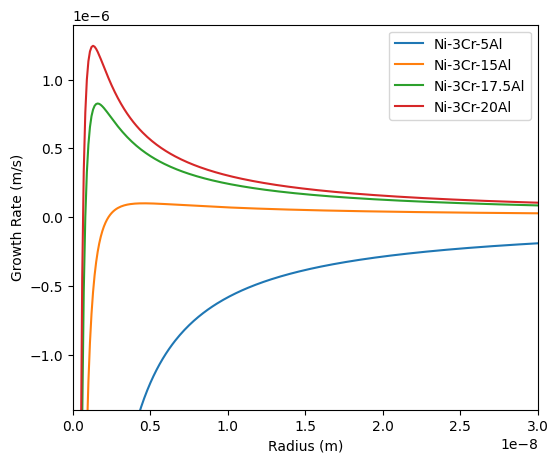

In [8]:
#Set driving force method since driving forces are required for 
# calculating growth rate and interfacial compositions
multiTherm.setDrivingForceMethod('approximate')

#Gibbs-Thomson contribution from radius
gamma = 0.023        #Interfacial energy between FCC-Ni and Ni3Al
Vm = 1e-5           #Molar volume
R = np.linspace(1e-10, 3e-8, 300)
G = 2 * gamma * Vm / R

fig4 = plt.figure(4, figsize=(6, 5))
ax4 = fig4.add_subplot(111)

#Calculate growth rate for different sets of compositions
xset = {'Ni-3Cr-5Al': [0.03, 0.1], 'Ni-3Cr-15Al': [0.03, 0.15], 'Ni-3Cr-17.5Al': [0.03, 0.175], 'Ni-3Cr-20Al': [0.03, 0.2]}
T = 1273
for x in xset:
    #Clear cache since the compositions are quite different in values
    multiTherm.clearCache()

    #Calculate driving force and growth rate
    dg, xb = multiTherm.getDrivingForce(xset[x], T, returnComp=True)
    res = multiTherm.getGrowthAndInterfacialComposition(xset[x], T, dg, R, G, searchDir = xb)
    if res is not None:
        gr, ca, cb, _, _ = res
        ax4.plot(R, gr, label=x)

ax4.set_xlim([0, 3e-8])
ax4.set_ylim([-1.4e-6, 1.4e-6])
ax4.set_xlabel('Radius (m)')
ax4.set_ylabel('Growth Rate (m/s)')
ax4.legend(xset.keys())

## Interdiffusivity

For binary systems, the interdiffusivity (as used in the growth rate equation) must be defined separately from the other thermodynamic/kinetic terms. To be used in the Thermodynamics module, parameters for the diffusivity/mobility must be defined in the TDB database file (either as 'MF'/'MQ' for mobility or 'DF'/'DQ' for diffusivity). The method is defined as:

$ D = BinaryThermodynamics.getInterdiffusivity(x, T) $

The reference element for the interdiffusivity will be the first element in the list of elements used to define the Thermodynamics modules.

This method is also available for multicomponent systems, where $x$ must be defined as an array of the solute components and the method returns the interdiffusivity matrix of the solute components; however, it is not need for the KWN model as it is already accounted for when calculating the growth rate and interfacial compositions. The example below shows usage of this method for the Al-Zr system.

Text(0, 0.5, '$ln(D (m/s^2))$')

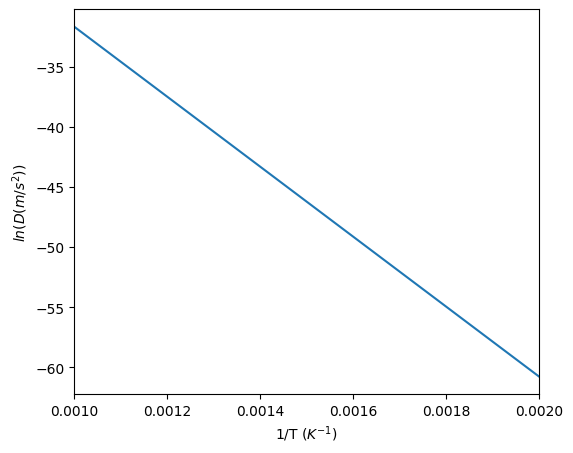

In [9]:
#Calculate interdiffusivity for various temperatures
T = np.linspace(500, 1000, 100)
d = binaryTherm.getInterdiffusivity(np.ones(100)*0.01, T)

fig5 = plt.figure(5, figsize=(6, 5))
ax5 = fig5.add_subplot(111)

#Arrhennius plot of diffusivities
ax5.plot(1/T, np.log(d))

ax5.set_xlim([1/1000, 1/500])
ax5.set_xlabel('1/T ($K^{-1}$)')
ax5.set_ylabel('$ln(D (m/s^2))$')

## Usage in the KWN model

The thermodynamics modules can be easily used in the KWN model as:

$ KWNModel.setThermodynamics(Thermodynamics) $

For binary systems, the interdiffusivity must be defined separately. This is to allow for user-defined functions. The interdiffusivity method can be inputted by:

$ KWNModel.setDiffusivity(BinaryThermodynamics.getInterdiffusivity) $